# MQ-9

## Garlic

### Specifications

#### Standard Work Condition

    Vc    (Circuit Voltage)        :  5v +/- 0.1
    VH(h) (Heating Voltage - high) :  5v +/- 0.1
    VH(l) (Heating Voltage - low)  :  1.4v +/- 0.1
    RL    (Load Resistance)        :  can adjust
    RH    (Heater Resistance)      :  33 Ohm +/- 5%
    TH(H) (Heating time (high)     :  60 +/- 1 seconds
    TH(L) (Heating time (low)      :  90 +/- 1 seconds
    PH    (Heating consumption)    :  less than 340 mW
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 2kOhm  -  20kOhm (100ppm Carbon Monoxide)
    Preheat Time               : No less than 48 hours
    
    Detecting range:
        Carbon Monoxide :  20ppm  - 2000ppm 
        CH4             :  500ppm - 10000ppm 
        LPG             :  500ppm - 10000ppm 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet
POINTS = {
    # Liquefied Petroleum Gas
    'lpg' : {
        'p1' : {'x': 50,   'y': 2.092},
        'p2' : {'x': 500,  'y': 1.361},
        'p3' : {'x': 800,  'y': 1.108},
        'p4' : {'x': 1000, 'y': 1.000},
        'p5' : {'x': 1500, 'y': 0.824},
        'p6' : {'x': 2000, 'y': 0.726},
        'p7' : {'x': 3000, 'y': 0.594},
        'p8' : {'x': 5000, 'y': 0.464},
        'p8' : {'x': 10000,'y': 0.332}
    },

    # Carbon Monoxide
    'co' : {
        'p1' : {'x': 50,   'y': 1.631},
        'p2' : {'x': 500,  'y': 1.068},
        'p3' : {'x': 800,  'y': 0.869},
        'p4' : {'x': 1000, 'y': 0.785}
    },

    # Methane
    'ch4' : {
        'p1' : {'x': 50,   'y': 3.122},
        'p2' : {'x': 500,  'y': 2.294},
        'p3' : {'x': 800,  'y': 1.913},
        'p4' : {'x': 1000, 'y': 1.769},
        'p5' : {'x': 1500, 'y': 1.539},
        'p6' : {'x': 2000, 'y': 1.372},
        'p7' : {'x': 3000, 'y': 1.173},
        'p8' : {'x': 5000, 'y': 0.949},
        'p8' : {'x': 10000,'y': 0.701}
    }  
}



AIR = 9.774

GASES = ['lpg', 'co', 'ch4']

In [3]:
# RS value calculation
Rs    = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0    = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
# m
M     = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
# b
B     = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# PPM value calculation 
PPM   = lambda  y, m, b: 10 ** ((math.log10(y) - b) / m)

In [4]:
## Calculate the points to be used for the calculation of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
df = pd.read_csv('garlic_mq7-9.csv')

mq9_1 = pd.DataFrame({'volt': df["sensor4"]})
mq9_2 = pd.DataFrame({'volt': df["sensor5"]})
mq9_3 = pd.DataFrame({'volt': df["sensor6"]})

### Ro values to be considered

- __Sensor 1__: 33.78  kOhms
- __Sensor 2__: 219.22 kOhms
- __Sensor 3__: 31.24  kOhms

In [7]:
# MQ 9 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR   
sensor1['Ro']  = 33.78  #kOhms


# MQ 9 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 219.22 #kOhms

# MQ 9 - sensor 3
sensor3 = {}
sensor3['Vcc'] = 5      #volts
sensor3['RL']  = 10     #kOhms
sensor3['AIR'] = AIR   
sensor3['Ro']  = 31.24  #kOhms


In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq9_1['volt'].min(),
    mq9_1['volt'].mean(), 
    mq9_1['volt'].quantile(0.25),
    mq9_1['volt'].quantile(0.5),
    mq9_1['volt'].quantile(0.75),
    mq9_1['volt'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq9_2['volt'].min(),
    mq9_2['volt'].mean(), 
    mq9_2['volt'].quantile(0.25),
    mq9_2['volt'].quantile(0.5),
    mq9_2['volt'].quantile(0.75),
    mq9_2['volt'].max()]

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

In [10]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq9_3['volt'].min(),
    mq9_3['volt'].mean(), 
    mq9_3['volt'].quantile(0.25),
    mq9_3['volt'].quantile(0.5),
    mq9_3['volt'].quantile(0.75),
    mq9_3['volt'].max()]

sensor3['Rs'] = [Rs(sensor3['Vcc'] , v, sensor3['RL'] ) for v in Vrl]
sensor3['Ratio'] = [Ratio(rs, sensor3['Ro']) for rs in sensor3['Rs']]

ppm3 = {}
for gas in GASES:
    ppm3[gas] = []

for r in sensor3['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm3[gas].append(PPM(r, m, b))

In [11]:
def printMM3QM(name, sensor, ppm):
    print(name)

    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format('Rs/Ro', 
                   round(sensor['Ratio'][0],3),
                   round(sensor['Ratio'][1],3),
                   round(sensor['Ratio'][2],3),
                   round(sensor['Ratio'][3],3),
                   round(sensor['Ratio'][4],3),
                   round(sensor['Ratio'][5],3)))

    for gas in GASES:
        print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
               .format(gas.upper(), 
                       round(ppm[gas][0],3),
                       round(ppm[gas][1],3),
                       round(ppm[gas][2],3),
                       round(ppm[gas][3],3),
                       round(ppm[gas][4],3),
                       round(ppm[gas][5],3)))

In [12]:
printMM3QM("Sensor1", sensor1, ppm1)

print("-"*(12*7))

printMM3QM("Sensor2", sensor2, ppm2)

print("-"*(12*7))

printMM3QM("Sensor3", sensor3, ppm3)

print("-"*(12*7))

Sensor1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        11.09        9.669        9.572        9.572        9.572        8.955       
LPG          0.007        0.014        0.015        0.015        0.015        0.021       
CO           0.001        0.003        0.003        0.003        0.003        0.005       
CH4          0.004        0.011        0.012        0.012        0.012        0.019       
------------------------------------------------------------------------------------
Sensor2
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        22.763       8.504        11.358       7.557        7.557        5.656       
LPG          0.0          0.027        0.006        0.051        0.051        0.243       
CO           0.0          0.006        0.001        0.012        0.012        0.058       
CH4          0.0          0.028        0.003        0.068        0.068        0.

In [13]:
font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

In [14]:
# Sensor 1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq9_1["volt"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []
    
for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq9_1[gas] = [ round(val, 3) for val in ppm1[gas]]

print(mq9_1.head())

   volt    lpg     co    ch4
0  0.15  0.015  0.003  0.012
1  0.15  0.015  0.003  0.012
2  0.15  0.015  0.003  0.012
3  0.16  0.021  0.005  0.019
4  0.15  0.015  0.003  0.012


In [15]:
# Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq9_2["volt"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []
    
for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq9_2[gas] = [ round(val, 3) for val in ppm2[gas]]

print(mq9_2.head())

   volt    lpg     co    ch4
0  0.03  0.051  0.012  0.068
1  0.02  0.006  0.001  0.003
2  0.03  0.051  0.012  0.068
3  0.02  0.006  0.001  0.003
4  0.02  0.006  0.001  0.003


In [16]:
# Sensor 3

sensor3['Rs'] = [Rs(sensor3['Vcc'] , v, sensor3['RL'] ) for v in mq9_3["volt"]]
sensor3['Ratio'] = [Ratio(rs, sensor3['Ro']) for rs in sensor3['Rs']]

ppm3 = {}
for gas in GASES:
    ppm3[gas] = []
    
for r in sensor3['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm3[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq9_3[gas] = [ round(val, 3) for val in ppm3[gas]]

print(mq9_3.head())

   volt    lpg     co    ch4
0  0.16  0.014  0.003  0.011
1  0.16  0.014  0.003  0.011
2  0.16  0.014  0.003  0.011
3  0.17  0.019  0.004  0.017
4  0.16  0.014  0.003  0.011


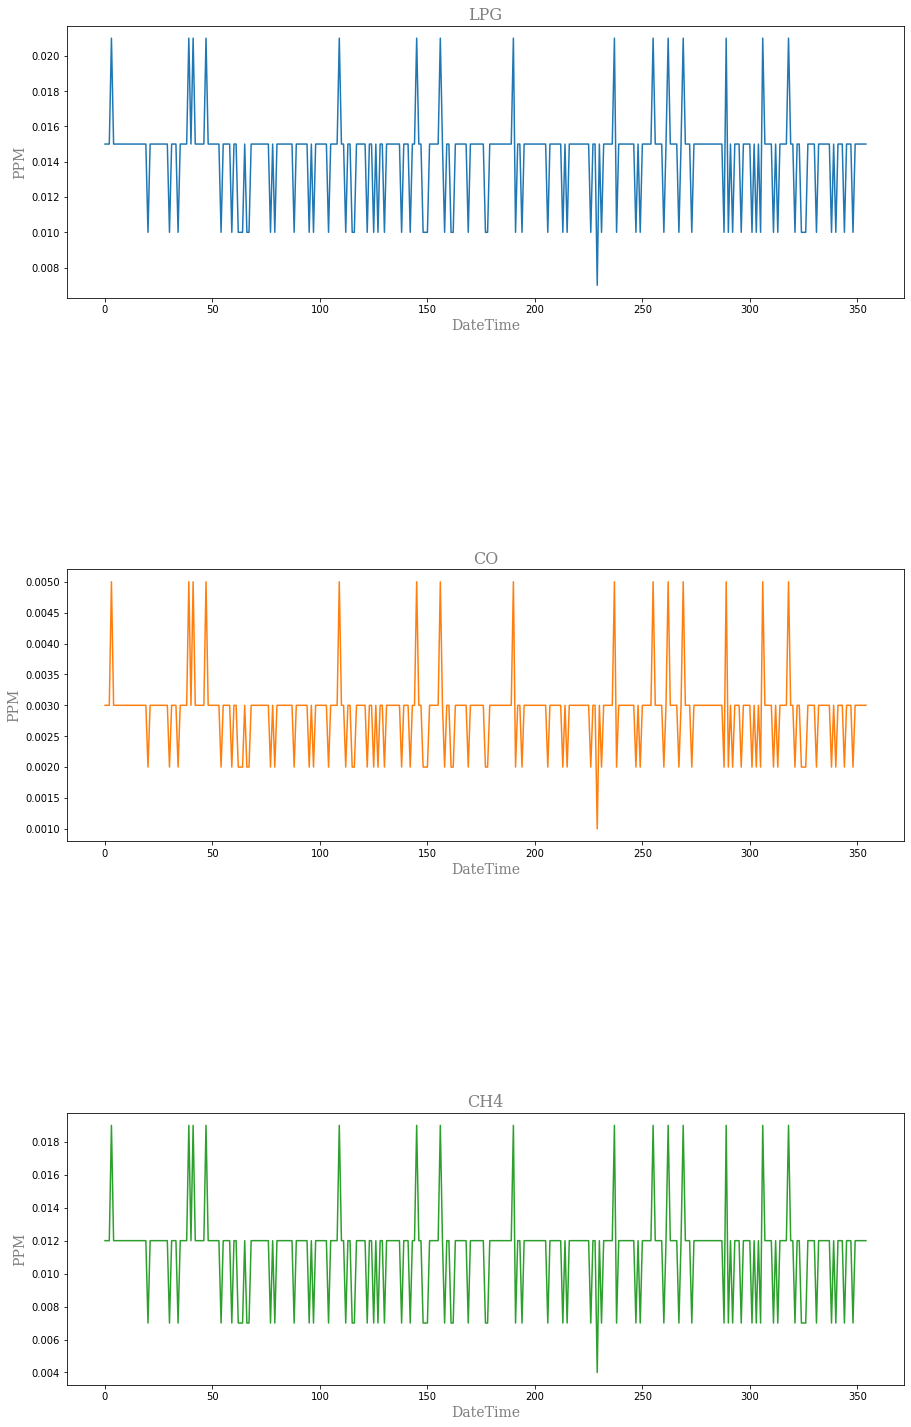

In [17]:
# Sensor 1
plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(mq9_1[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

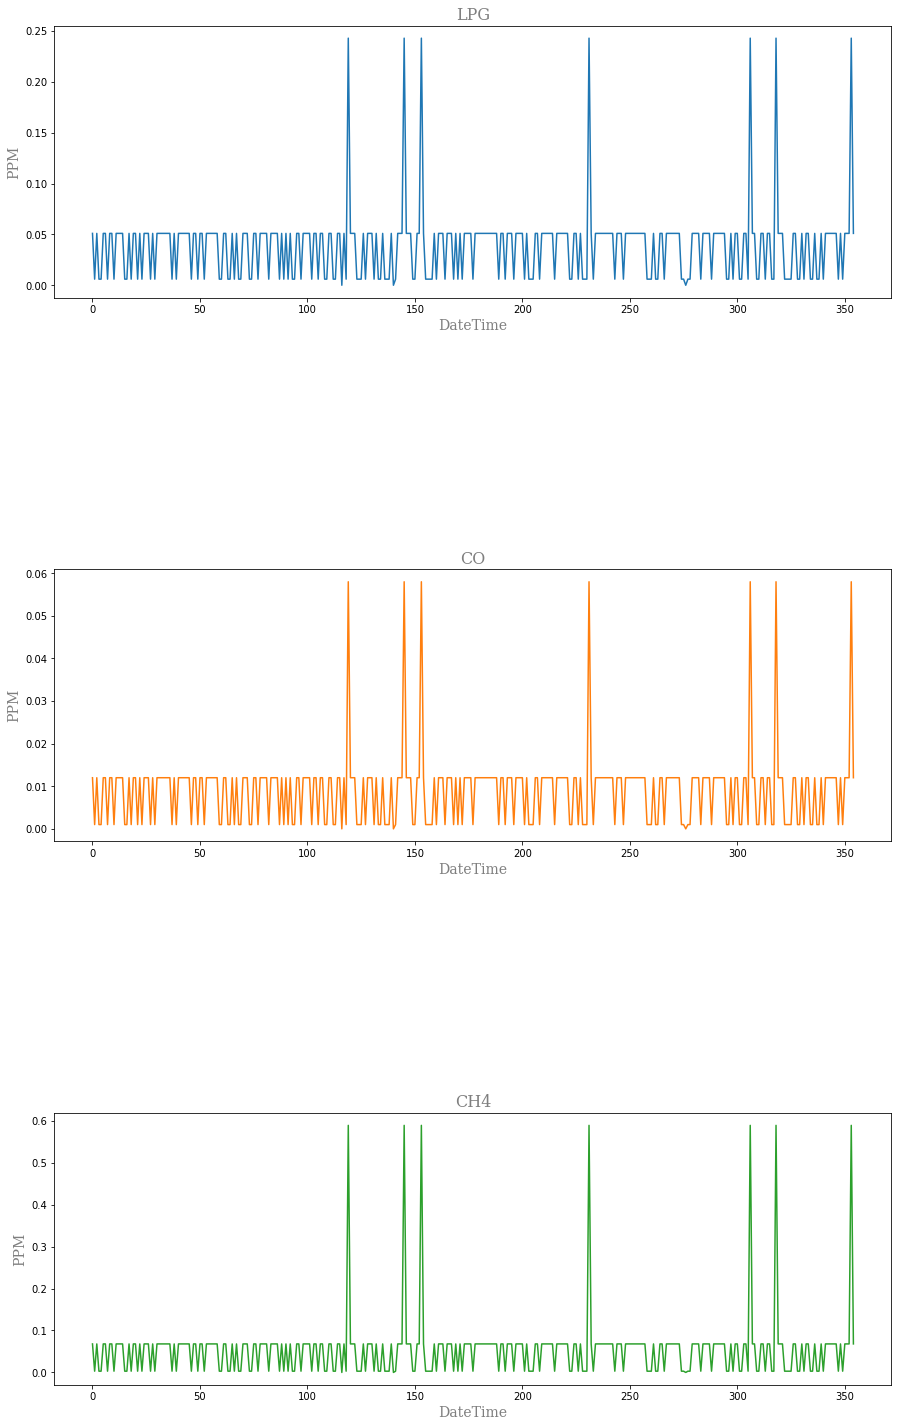

In [18]:
# Sensor 2
plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(mq9_2[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

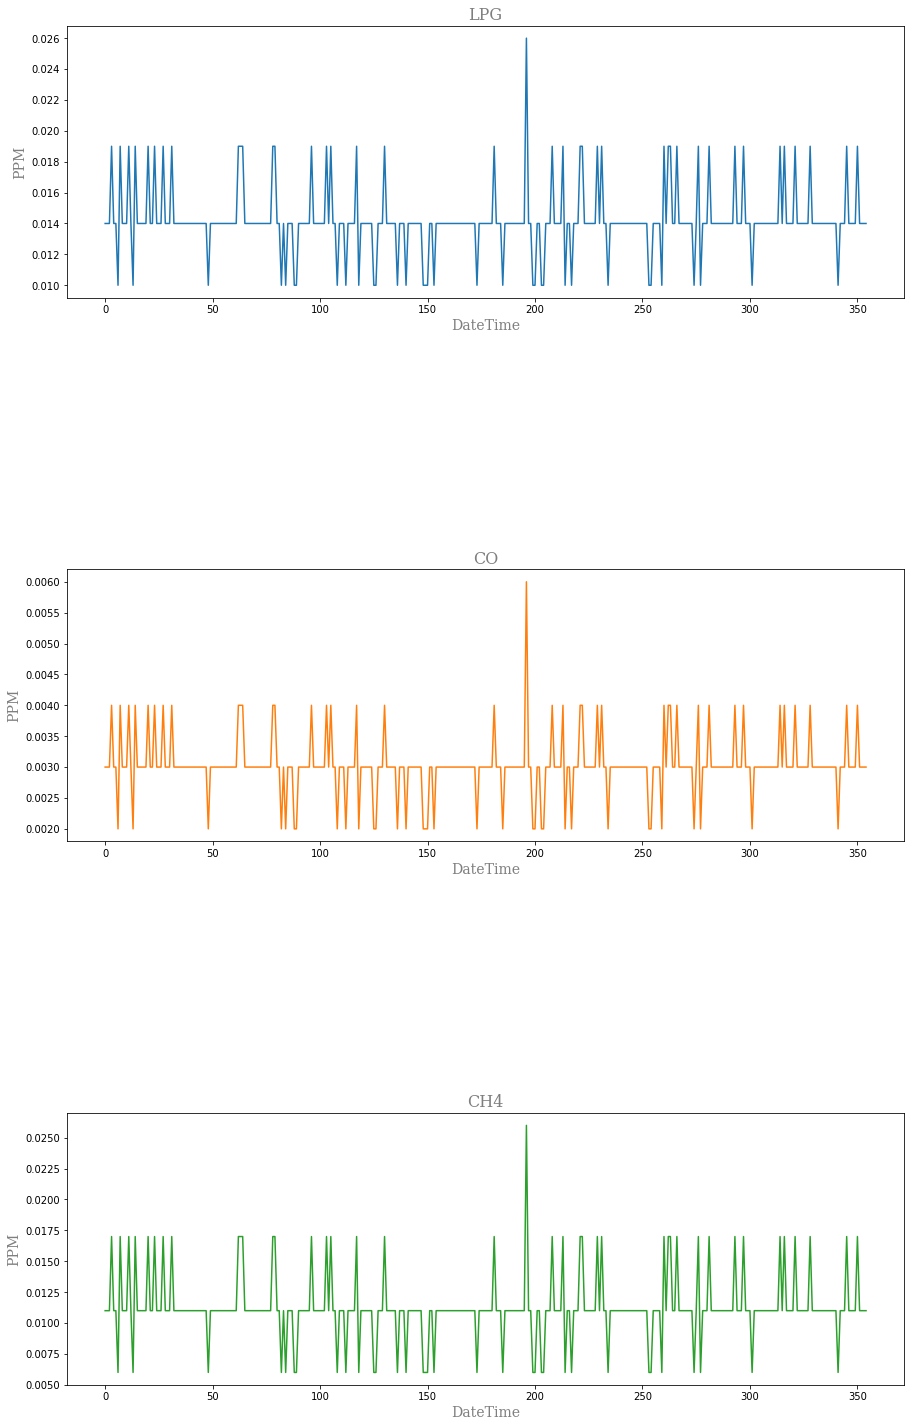

In [19]:
# Sensor 3
plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(mq9_3[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

In [20]:
# Save in csv file
mq9_1.to_csv('mq9_1.csv')
mq9_2.to_csv('mq9_2.csv')
mq9_3.to_csv('mq9_3.csv')